# Experiment 003

Here we try again to train an auxiliary model to identify when a block has landed, but we make sure to provide a balanced dataset.

Before running the code, make sure to have a folder called `data_block_landing` with a large number (say 500 at least) of recording files. This is because we will prune most of them out to balance between the classes of "no block landed" and "block landed".

In [1]:
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class RecordingFolder:
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it))

    def __iter__(self):
        return RecordingFolderIterator(self)
    
    def __len__(self):
        return self.highest_index
    
    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        return file
    
    def delete_items(self, idxs):
        for idx in idxs:
            file = os.path.join(self.path, f"{idx}{self.ext}")
            os.remove(file)
        self.reindex()
    
    def reindex(self):
        with os.scandir(self.path) as it:
            self.highest_index = max((int(Path(file.path).stem) for file in it))
        for i1 in range(self.highest_index+1):
            f1 = os.path.join(self.path, f"{i1}{self.ext}")
            if os.path.exists(f1):
                continue
            for i2 in range(i1+1, self.highest_index+1):
                f2 = os.path.join(self.path, f"{i2}{self.ext}")
                if os.path.exists(f2):
                    os.rename(f2, f1)
                    break
        with os.scandir(self.path) as it:
            self.highest_index = max((int(Path(file.path).stem) for file in it))


class RecordingFolderIterator:
    def __init__(self, folder: RecordingFolder):
        self.folder = folder
        self.idx = 0

    def __next__(self):
        self.idx += 1
        try:
            return self.folder[self.idx]
        except IndexError:
            raise StopIteration()

In [3]:
# Check we can iterate over files.
folder = RecordingFolder("data_block_landing")
file = next(iter(folder))
print(file)
print(f"{len(folder)} files in total")

data_block_landing\1.npy
1006 files in total


In [4]:
# Check we can read the files.
np.load(file)

array([[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

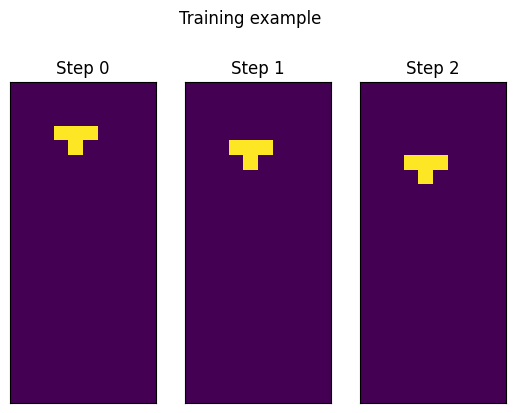

In [8]:
def show_example(file):
    boards = np.load(file)

    fig, axs = plt.subplots(1, len(boards))
    fig.suptitle("Training example")

    for i, ax in enumerate(axs):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(f"Step {i}")
        ax.imshow(boards[i])

    plt.show()


show_example(file)

Showing example 160


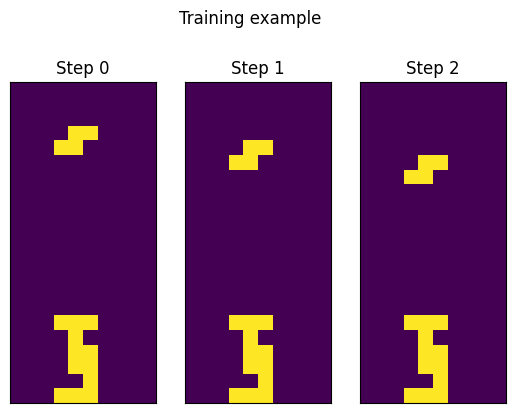

In [18]:
# Show a random example from the training set. Run this repeatedly to get an overview of the data.

idx = random.randint(1, len(folder))
print(f"Showing example {idx}")
file = folder[idx]
show_example(file)

In [19]:
for file in folder:
    boards = np.load(file)
    if np.max(boards) > 1:
        print(f"File {file} has invalid cells.")
        os.remove(file)

folder.reindex()

File data_block_landing\93.npy has invalid cells.
File data_block_landing\317.npy has invalid cells.
File data_block_landing\362.npy has invalid cells.
File data_block_landing\406.npy has invalid cells.


In [20]:
num_blocks_landing = 0

for file in folder:
    boards = np.load(file)
    b1 = boards[1] # We can identify a block landing by the fact that a block spawns in the next time step
    b2 = boards[2]
    block_landing = (np.all(b1[0] == 0) & np.any(b2[0] == 1)).item()
    if block_landing:
        num_blocks_landing += 1
    
print(f"Blocks landing: {num_blocks_landing/len(folder)*100:.2f}% ({num_blocks_landing}/{len(folder)})")

Blocks landing: 4.80% (24/500)


# Removing the imbalance

Let's remove the imbalance by pruning out some of the training data at random.

In [21]:
num_to_prune = len(folder) - 2*num_blocks_landing

idxs = list(range(1, len(folder)+1))
random.shuffle(idxs) # Try the indices in a random order

for i in idxs:
    if num_to_prune <= 0:
        break
    file = folder[i]
    boards = np.load(file)
    b1 = boards[1] # We can identify a block landing by the fact that a block spawns in the next time step
    b2 = boards[2]
    block_landing = (np.all(b1[0] == 0) & np.any(b2[0] == 1)).item()
    if block_landing: # Don't prune files where the block is landing
        continue
    print(f"Pruning file {file}")
    os.remove(file)
    num_to_prune -= 1

folder.reindex()

Pruning file data_block_landing\421.npy
Pruning file data_block_landing\377.npy
Pruning file data_block_landing\338.npy
Pruning file data_block_landing\327.npy
Pruning file data_block_landing\216.npy
Pruning file data_block_landing\487.npy
Pruning file data_block_landing\217.npy
Pruning file data_block_landing\107.npy
Pruning file data_block_landing\348.npy
Pruning file data_block_landing\153.npy
Pruning file data_block_landing\61.npy
Pruning file data_block_landing\261.npy
Pruning file data_block_landing\486.npy
Pruning file data_block_landing\185.npy
Pruning file data_block_landing\187.npy
Pruning file data_block_landing\121.npy
Pruning file data_block_landing\325.npy
Pruning file data_block_landing\140.npy
Pruning file data_block_landing\408.npy
Pruning file data_block_landing\458.npy
Pruning file data_block_landing\258.npy
Pruning file data_block_landing\22.npy
Pruning file data_block_landing\484.npy
Pruning file data_block_landing\430.npy
Pruning file data_block_landing\159.npy
Pr

In [22]:
num_blocks_landing = 0

for file in folder:
    boards = np.load(file)
    b1 = boards[1] # We can identify a block landing by the fact that a block spawns in the next time step
    b2 = boards[2]
    block_landing = (np.all(b1[0] == 0) & np.any(b2[0] == 1)).item()
    if block_landing:
        num_blocks_landing += 1
    
print(f"Blocks landing: {num_blocks_landing/len(folder)*100:.2f}% ({num_blocks_landing}/{len(folder)})")

Blocks landing: 50.00% (24/48)


# Training

In [23]:
class BlockLandingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it))

    def __len__(self):
        return self.highest_index

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx+1}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = boards[:2] # Just take the first two frames as that's what will be input to the main model
        b1 = boards[1] # We can identify a block landing by the fact that a block spawns in the next time step
        b2 = boards[2]
        y = (np.all(b1[0] == 0) & np.any(b2[0] == 1)).astype(np.float32)
        x, y = torch.tensor(x), torch.tensor(y)
        return x, y
        

In [24]:
dataset = BlockLandingDataset("data_block_landing")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

x, y = next(iter(dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 2, 22, 10]) torch.int32
torch.Size([4]) torch.float32


In [25]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [26]:
class BlockLandingModel(nn.Module):
    """Predicts whether a block has landed.

    Inputs:
        x: Tensor of int32 of shape (batch_size, seq_length, height, width). height = 22 and width = 10 are the dimensions of the game
           board. seq_length = 2 is the number of game board inputs. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: float32 scalar, logit for block landing prediction.
    """

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.GRU(5, 5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately
        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1) # TODO: Ideally want global average pool that's size-independent
        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin(x).squeeze(-1)
        return logits

In [27]:
model = BlockLandingModel().to(device)
print(model)

with torch.no_grad():
    X, y = next(iter(dataloader))
    logits = model(X)[0]
    preds = F.sigmoid(logits)
    print(f"Predicted states: {preds}")

BlockLandingModel(
  (conv): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
  (rnn): GRU(5, 5)
  (lin): Linear(in_features=5, out_features=1, bias=True)
)
Predicted states: 0.46685802936553955


In [29]:
def train_loop(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    recall = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            classes = (pred >= 0).type(torch.float)
            correct += (classes == y).type(torch.float).mean().item()
            recall += ((classes == 1.0) & (y == 1.0)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= num_batches
    recall /= num_block_landings
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Recall: {(100*recall):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {
        "loss": test_loss,
        "acc": correct,
        "recall": recall
    }

In [44]:
learning_rate = 1e-2
batch_size = 4
epochs = 200

model = BlockLandingModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
acc_history = []
recall_history = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
    epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
    loss_history.append(epoch_loss)
    # No need to plot test loss separately as in our case it's the same as training loss
    test_metrics = test_loop(dataloader, model, loss_fn)
    acc_history.append(test_metrics["acc"])
    recall_history.append(test_metrics["recall"])

print("Done!")

Epoch 1
-------------------------------
loss: 0.709829  [    4/   48]
Test Error: 
 Accuracy: 50.0%, Recall: 0.0%, Avg loss: 0.709233 

Epoch 2
-------------------------------
loss: 0.894493  [    4/   48]
Test Error: 
 Accuracy: 50.0%, Recall: 0.0%, Avg loss: 0.707519 

Epoch 3
-------------------------------
loss: 0.706494  [    4/   48]
Test Error: 
 Accuracy: 50.0%, Recall: 0.0%, Avg loss: 0.705971 

Epoch 4
-------------------------------
loss: 0.705641  [    4/   48]
Test Error: 
 Accuracy: 50.0%, Recall: 0.0%, Avg loss: 0.704573 

Epoch 5
-------------------------------
loss: 0.861585  [    4/   48]
Test Error: 
 Accuracy: 50.0%, Recall: 0.0%, Avg loss: 0.703312 

Epoch 6
-------------------------------
loss: 0.703111  [    4/   48]
Test Error: 
 Accuracy: 50.0%, Recall: 0.0%, Avg loss: 0.702189 

Epoch 7
-------------------------------
loss: 0.772105  [    4/   48]
Test Error: 
 Accuracy: 50.0%, Recall: 0.0%, Avg loss: 0.701178 

Epoch 8
-------------------------------
loss: 0.

[]

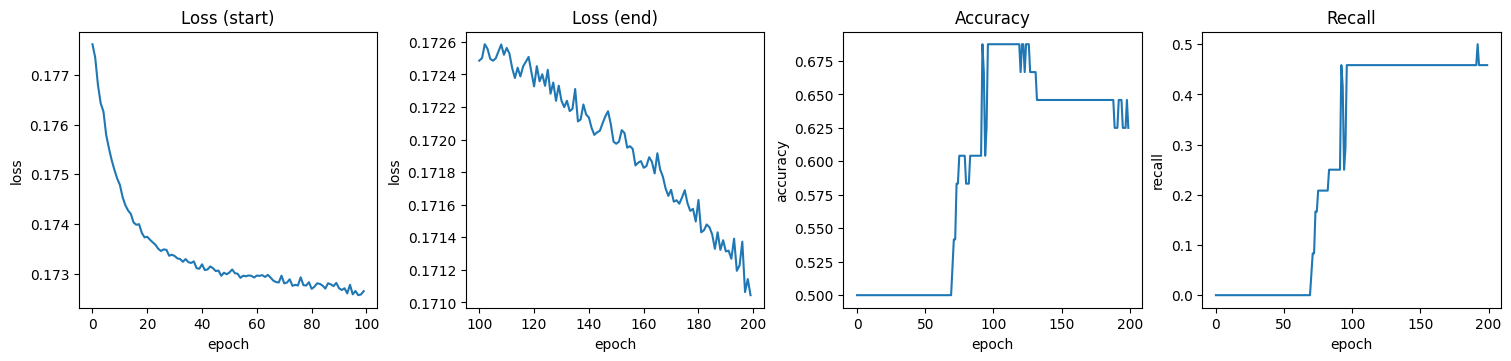

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_recall = axs

ax_loss_1.plot(loss_history[:epochs//2])
ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:])
ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.plot(acc_history)
ax_acc.set_title("Accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_recall.plot(recall_history)
ax_recall.set_title("Recall")
ax_recall.set_xlabel("epoch")
ax_recall.set_ylabel("recall")

plt.plot()

In [46]:
def show_prediction(idx):
    x, y = dataset[idx]
    x1, x2 = x
    pred = model(x.unsqueeze(0)).squeeze(0)

    fig, axs = plt.subplots(1, 2)
    fig.suptitle("Example")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Step 0")
    axs[1].set_title("Step 1")

    axs[0].imshow(x1)
    axs[1].imshow(x2)

    print(f"Predicted: {pred >= 0}, Actual: {y == 1.0}")
    plt.show()

Showing prediction for example 38
Predicted: False, Actual: True


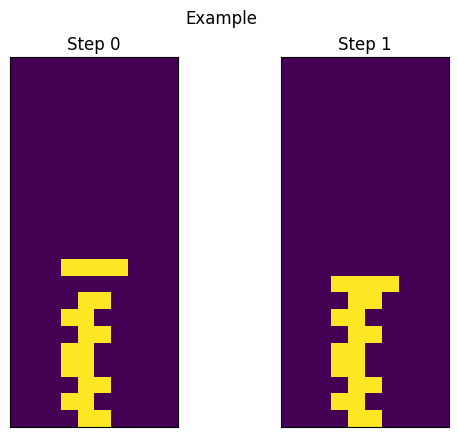

In [51]:
# Show a random prediction vs reality
import random

idx = random.randrange(len(dataset))
print(f"Showing prediction for example {idx+1}")
show_prediction(idx)

# Conclusion

We have shown that the current model can achieve over 60% accuracy on a balanced training set for the block landing problem, though it takes a long time to do so. This suggests that the dataset imbalance was at least partly responsible for the original failure of the model to identify any block landings.